# Criticality with an underlying network

In this notebook, we conduct LD experiments with an underlying network. 

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tikzplotlib
from tqdm import tqdm
import pandas as pd
import networkx as nx

## Voting power with underlying network

The following cells contains the code to compute the criticality of voters with a given underlying network

In [2]:
def create_bill_LD(n, network):
    '''
    This function create a delegation partition for LD,  
    It select with v_d if voters delegate (v_d_d[i] = 0) or vote directly
    Then we will look at v_1 if they vote directly, v_2 if they delegate and we take care of avoiding self delegations.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_d = np.zeros(n, dtype=int)
    v_1 = np.random.randint(2, size=(n), dtype=int)
    v_2 = np.zeros(n, dtype=int)
    for i in range(n):
        neighbors = list(nx.neighbors(network, i))
        if 2/(len(neighbors)+2) >= np.random.rand():
            v_d[i] = 1
            continue
        v_2[i] = neighbors[np.random.randint(len(neighbors))]            
    return v_d, v_1, v_2

In [3]:
def compute_result(v_d, v_1, v_2, weights):
    '''
    This function takes as input a delegation instance, and weights of voters, and compute the results of the election in
    this delegation instance
    '''
    n = len(v_d)
    
    # V is the vector of final vote (+1, -1 or 0 if the voter is abstaining)
    v = np.zeros(n)
    
    # We push in q all the delegating voters
    q = []
        
    for i in range(n):
        if v_d[i]:
            v[i] = 2*v_1[i]-1
        else:
            q.append(i)
            
            
    # We propagate the vote of direct voters to the voters delegating to them until we've seen all the voters
    # The idea is similar to a DFS, but in a tree.
    abst = []
    while q != []:
        x = q.pop()
        if x in abst or v[x] != 0:
            continue
        seen = []
        while x not in seen and x not in abst and v[x] == 0:
            seen.append(x)
            x = v_2[x]
        
        if x in seen or x in abst:
            for y in seen:
                if y not in abst:
                    abst.append(y)
        else:
            r = v[x]
            for y in seen:
                v[y] = r
                
    # We compute the results
    r = v.dot(weights)
    
    return r >=0, v

def test_critical_LD( network, weights):
    '''
    This function takes as input the number of voters, the probability to delegate and the weights
    in the LD setting, create a delegation partition, and count the number of voters in each group that are critical.
    We assume that we are in a WVG with q = 0.5. We also assume that weights are natural number between 1 and 9.
    '''
    n = len(network)
    v_d, v_1, v_2 = create_bill_LD(n, network)
    res, v = compute_result(v_d, v_1, v_2, weights)
    
    power = np.zeros(n)
    
    # We look for every voter that agree with the result if the result would change if this voter changes his vote.
    for i in range(n):
        res2 = res
        if v[i] != -1 and res == 1:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 0
            res2, _ = compute_result(v_d_copy, v_1_copy, v_2, weights)
            
        elif v[i] != 1 and res == 0:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 1
            res2, _ = compute_result(v_d_copy, v_1_copy, v_2, weights)
        if res != res2:
            power[i] = 1
    
    
    return power
            
    

In [4]:
def network_powers(network, weights, n_trys= 10000):
    """
    This function will estimate the criticality of every node in the graph.
    """
    n = len(network)
    powers = np.zeros(n)
    for _ in tqdm(range(n_trys)):
        powers += test_critical_LD(network, weights)
        
    return powers/n_trys
    

## Model generators

In this part of the notebook, we present how to create the different types of networks

### Complete graph

In [20]:
def network_complete(n_voters):
    """
    This function generate a complete graph
    """
    return nx.complete_graph(n_voters, nx.DiGraph())

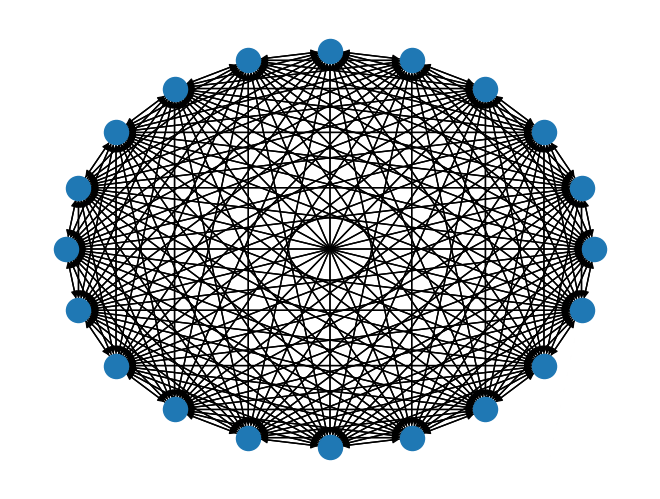

In [21]:
G = network_complete(20)
nx.draw_circular(G)

### Random graph

The $G(n,p)$ model.

In [22]:
def network_random(n_voters, proba_edges):
    m_edges = int(proba_edges*n_voters*(n_voters-1)/2)
    
    return nx.gnm_random_graph(n_voters, m_edges)

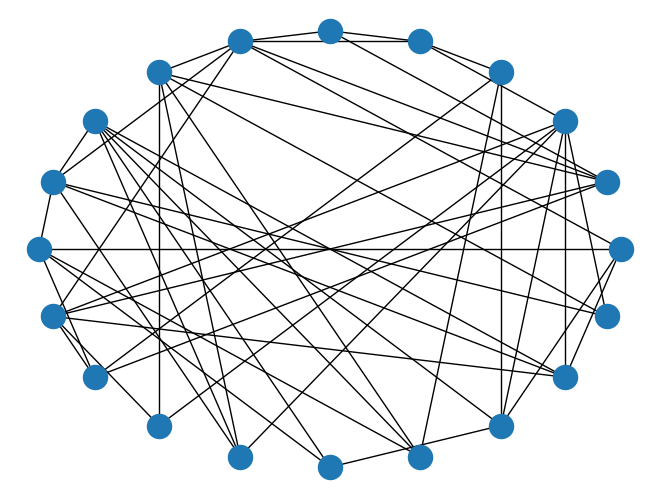

In [23]:
G = network_random(20,0.25)
nx.draw_circular(G)

### k-layers graph

A graph with $k$ layer and each layer can only delegate to the next

In [24]:
def network_k_partite(n_voters):
    """
    This function generate a graph with k level and each level is totally connected to the next one (neural network style).
    """
    
    e_list = []
    s = 0
    for k in range(len(n_voters)-1):
        for i in range(n_voters[k]):
            for j in range(n_voters[k+1]):
                e_list.append((s+i,s+n_voters[k]+j))
        s += n_voters[k]
    network = nx.DiGraph()
    network.add_nodes_from(range(np.sum(n_voters)))
    network.add_edges_from(e_list)
    return network


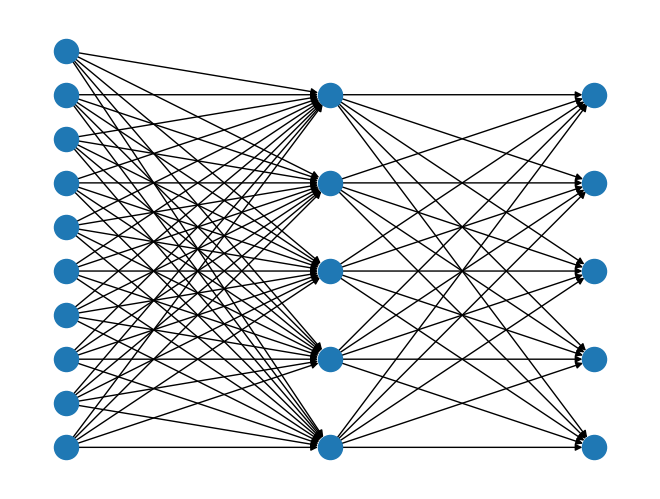

In [25]:
G = network_k_partite([10,5,5])
nx.draw(G,[[0,0.1*i] for i in range(10)] + [(1,0.2*i) for i in range(5)] + [(2,0.2*i) for i in range(5)])

### Preferential attachment

A preferential attachment model based on the _Barabasi-Albert_ model

In [22]:
def network_preferential_attachment(n_voters, proba_edges, avg_in_degree = None):
    """
    This function generate a graph based on the Barabasi Albert preferential attachment model
    NOTE : it does not generate a DiGraph
    """
    m_edges = int(n_voters*proba_edges/(2+proba_edges))
    return nx.barabasi_albert_graph(n_voters, m_edges)

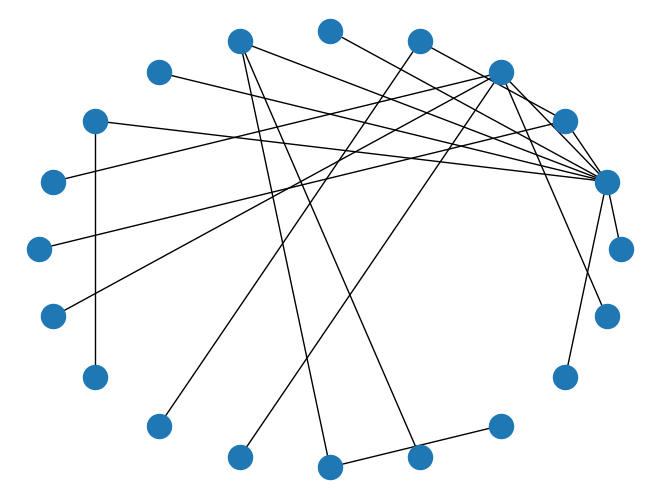

In [23]:
G = network_preferential_attachment(20,0.2)
nx.draw_circular(G)

### Small world

A small world model based on the _Watts-Strogatz_ model

In [28]:
def network_small_world(n_voters, k_neighbours, p_rewiring):
    """
    This function generate a graph based on the watts strogatz small world model
    """
    return nx.watts_strogatz_graph(n_voters, k_neighbours, p_rewiring)

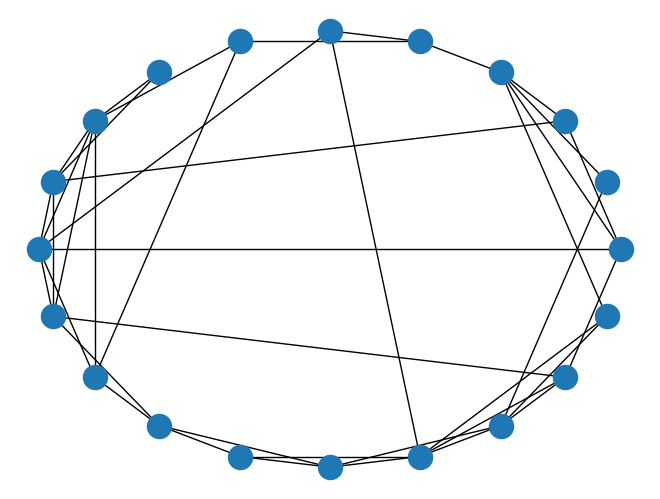

In [29]:
G = network_small_world(20,4, 0.25)
nx.draw_circular(G)

### Spatial model

A spatial model in which a voter delegate to the $k$ closest neighbours

In [48]:
def matrix_dist(pos):
    n = len(pos)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            M[i, j] = np.sqrt((pos[i][0] - pos[j][0]) ** 2 + (pos[i][1] - pos[j][1]) ** 2)
            M[j, i] = np.sqrt((pos[i][0] - pos[j][0]) ** 2 + (pos[i][1] - pos[j][1]) ** 2)

    return M



def network_spatial(n_voters, k_neighbors, distrib_x="uniform", distrib_y="uniform"):
    """
    Create a synthetic delegation network with the spatial method. In this method, first we put every voter
    on a 2D plane, then each delegating voter delegates to the voters the closest to him.

    Parameters
    ----------
    n_voters
        Number of voters in the election

    p_casting
        Proportion of casting voters in the election

    n_delegatees
        Number of delegatees per voters

    distrib_x
        Distribution for the x coordinate (either "gaussian" or "uniform")

    distrib_y
        Distribution for the y coordinate (either "gaussian" or "uniform")

    Returns
    -------
    election: Election
        The Election with voters
    pos: list
        The list of position of voters on the spatial plane

    """

    distribs = [distrib_x, distrib_y]
    pos = np.zeros((n_voters, 2))
    for j in range(2):
        if distribs[j] == "uniform":
            pos[:,j] = np.random.rand(n_voters)*2-1
        elif distribs[j] == "gaussian":
            pos[:,j] = np.random.normal(size=n_voters)
 
    M = matrix_dist(pos)
    edges_list = []
    for i in range(n_voters):
        list_neighbors = np.argsort(M[i])[1:k_neighbors+1]
        for x in list_neighbors:
            edges_list.append((i,x))

    network = nx.DiGraph()
    network.add_nodes_from([(x, {"x":pos[x,0], "y":pos[x,1]}) for x in range(n_voters)])
    network.add_edges_from(edges_list)
    return network


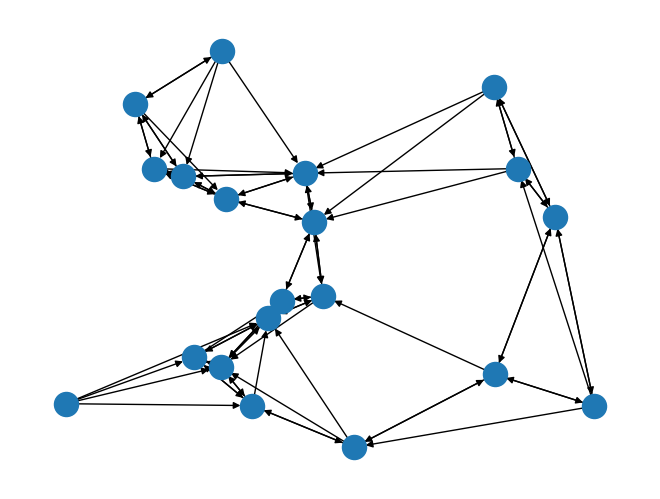

In [31]:
G = network_spatial(20,4)
nx.draw(G, [[G.nodes[i]["x"], G.nodes[i]["y"]] for i in range(20)])

## Network generation

In the following section, we sample graphs of different types :

* Random $G(n,p)$
* Spatial
* Preferential attachment
* Small world
* $5$-layers

In [32]:
n_voters = 100
for k in range(5):
    G = network_random(n_voters,0.1)
    powers = network_powers(G, np.ones(n_voters), n_trys=5000)
    pd.DataFrame(powers).to_csv("graph/1_power_Gnm_%i.csv"%(k), header=["power"])
    pd.DataFrame(list(G.edges)).to_csv("graph/1_edges_Gnm_%i.csv"%(k), header=["edge_u","edge_v"])

100%|██████████| 5000/5000 [04:20<00:00, 19.17it/s]


In [49]:
n_voters = 100
for i, model in enumerate(["uniform", "gaussian"]):
    print(model)
    for k in range(5):
        G = network_spatial(n_voters, 10, model, model)
        powers = network_powers(G, np.ones(n_voters), n_trys=5000)
        pd.DataFrame(powers).to_csv("graph/%i_power_spatial_%s_%i.csv"%(i+2, model, k), header=["power"])
        pd.DataFrame(list(G.edges)).to_csv("graph/%i_edges_spatial_%s_%i.csv"%(i+2, model, k), header=["edge_u","edge_v"])

  0%|          | 5/5000 [00:00<03:35, 23.16it/s]

gaussian


100%|██████████| 5000/5000 [03:52<00:00, 21.48it/s]


In [24]:
for k in range(5):
    n_voters = 100
    G = network_preferential_attachment(n_voters,0.1)
    powers = network_powers(G, np.ones(n_voters), n_trys=5000)
    pd.DataFrame(powers).to_csv("graph/4_power_pref_%i.csv"%(k), header=["power"])
    pd.DataFrame(list(G.edges)).to_csv("graph/4_edges_pref_%i.csv"%(k), header=["edge_u","edge_v"])

100%|██████████| 5000/5000 [03:24<00:00, 24.45it/s]


In [36]:
for k in range(5):
    n_voters = 100
    G = network_small_world(n_voters,10,0.2)
    powers = network_powers(G, np.ones(n_voters), n_trys=5000)
    pd.DataFrame(powers).to_csv("graph/5_power_small_world_%i.csv"%(k), header=["power"])
    pd.DataFrame(list(G.edges)).to_csv("graph/5_edges_small_world_%i.csv"%(k), header=["edge_u","edge_v"])

100%|██████████| 5000/5000 [05:08<00:00, 16.22it/s]


In [37]:
for k in range(5):
    n_voters=100
    G = network_k_partite([10]*10)
    powers = network_powers(G, np.ones(n_voters))
    pd.DataFrame(powers).to_csv("graph/6_power_layers_%i.csv"%k, header=["power"])
    pd.DataFrame(list(G.edges)).to_csv("graph/6_edges_layers_%i.csv"%(k), header=["edge_u","edge_v"])

100%|██████████| 10000/10000 [02:08<00:00, 77.82it/s]


## Figures

We plot the distribution of criticality for the different networks

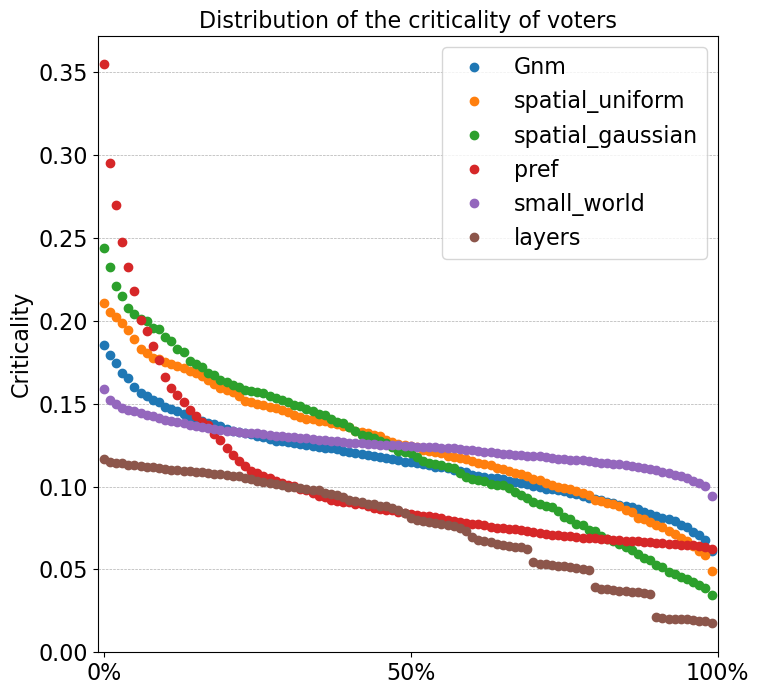

In [25]:
models = ["Gnm","spatial_uniform","spatial_gaussian","pref","small_world","layers"] 
n_voters = 100

plt.figure(figsize=(8,8))
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=16) #fontsize of the legend

for i, model in enumerate(models):
    
    distrib = np.zeros(n_voters)
    for k in range(5):
        df = pd.read_csv("graph/%i_power_%s_%i.csv"%(i+1,model,k), index_col=0)
        distrib += np.sort(df["power"].to_numpy())[::-1]
    plt.plot(distrib/5, 'o', linewidth=3, label=model)
    
    
ax = plt.gca()

plt.xticks([0,50,100], ["0%","50%", "100%"])
plt.legend()
plt.xlim(-1,100)
plt.ylim(0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.ylabel("Criticality")
tikzplotlib.save("figures_tikz/distribution_criticality.tex")
plt.title("Distribution of the criticality of voters")
plt.savefig("figures/distribution_criticality.png")
plt.show()

We also plot the distribution of in-degree

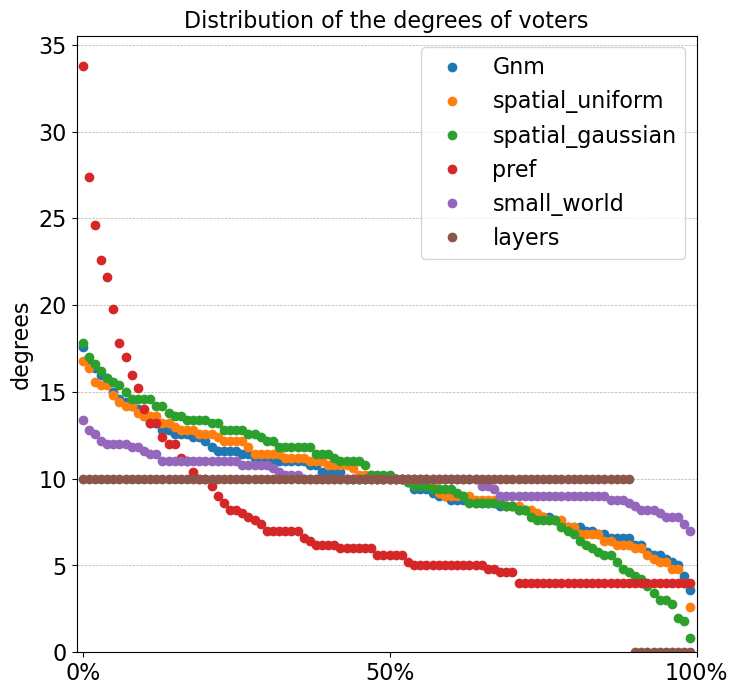

In [26]:
models = ["Gnm","spatial_uniform","spatial_gaussian","pref","small_world","layers"] 

plt.figure(figsize=(8,8))
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=16) #fontsize of the legend

for i, model in enumerate(models):
    distrib = np.zeros(n_voters)
    for k in range(5):
        dict_edge = {}
        for x in range(100):
            dict_edge[x] = []
        df = pd.read_csv("graph/%i_edges_%s_%i.csv"%(i+1,model,k), index_col=0)
        for u,v in df[["edge_u", "edge_v"]].to_numpy():
            dict_edge[v].append(u)
            
            if i in [0,3,4]:
                dict_edge[u].append(v)
                
        distrib += np.sort([len(dict_edge[u]) for u in dict_edge])[::-1]
    plt.plot(distrib/5, 'o', linewidth=3, label=model)
    
    
ax = plt.gca()

plt.xticks([0,50,100], ["0%","50%", "100%"])
plt.legend()
plt.xlim(-1,100)
plt.ylim(0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.ylabel("degrees")
tikzplotlib.save("figures_tikz/distribution_degrees.tex")
plt.title("Distribution of the degrees of voters")
plt.savefig("figures/distribution_degrees.png")
plt.show()

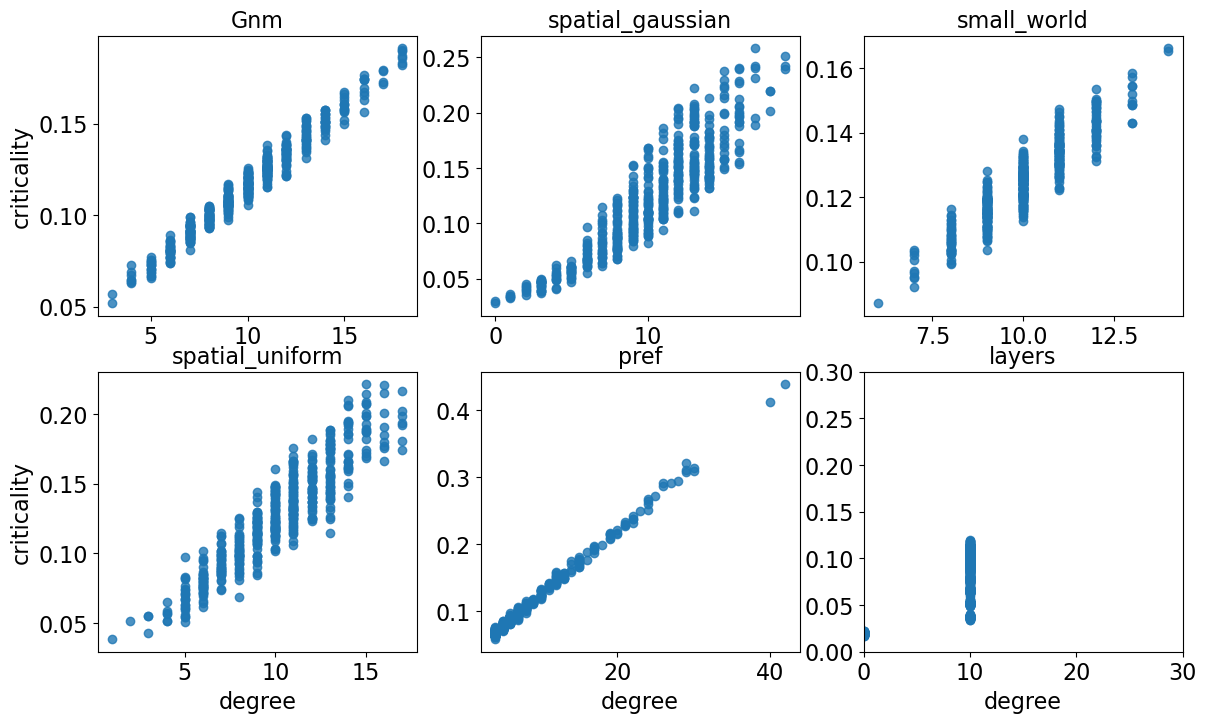

In [27]:
fig, axs = plt.subplots(2,3,figsize=(14,8))
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=16) #fontsize of the legend

for i, model in enumerate(models):
    
    tab_edges = []
    tab_power = []
    for k in range(5):
        dict_edge = {}
        for x in range(100):
            dict_edge[x] = []
        df_edges = pd.read_csv("graph/%i_edges_%s_%i.csv"%(i+1,model,k), index_col=0)
        df_power = pd.read_csv("graph/%i_power_%s_%i.csv"%(i+1,model,k), index_col=0)
        for u,v in df_edges[["edge_u", "edge_v"]].to_numpy():
            dict_edge[v].append(u)
            
            if i in [0,3,4]:
                dict_edge[u].append(v)

        tab_edges += [len(dict_edge[u]) for u in dict_edge]
        tab_power += df_power["power"].to_list()
                
    axs[i%2][i//2].scatter(tab_edges, tab_power, alpha=0.8)
    axs[i%2][i//2].set_title(model)
    if i//2 == 0:
        axs[i%2][i//2].set_ylabel("criticality")
    if i%2 == 1:
        axs[i%2][i//2].set_xlabel("degree")
    
    
    
#get current axes
ax = plt.gca()

plt.ylim(0,0.30)
plt.xlim(0,30)
# plt.title("Distribution of the number of neighbors")
tikzplotlib.save("figures_tikz/degree_edges.tex")
plt.savefig("figures/degree_edges.png")
plt.show()

In [28]:

plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=16) #fontsize of the legend

for i, model in enumerate(models):

    plt.figure(figsize=(8,5))
    
    tab_edges = []
    tab_power = []
    for k in range(5):
        dict_edge = {}
        for x in range(100):
            dict_edge[x] = []
        df_edges = pd.read_csv("graph/%i_edges_%s_%i.csv"%(i+1,model,k), index_col=0)
        df_power = pd.read_csv("graph/%i_power_%s_%i.csv"%(i+1,model,k), index_col=0)
        for u,v in df_edges[["edge_u", "edge_v"]].to_numpy():
            dict_edge[v].append(u)
            
            if i in [0,3,4]:
                dict_edge[u].append(v)
                
        tab_edges += [len(dict_edge[u]) for u in dict_edge]
        tab_power += df_power["power"].to_list()
                
    plt.scatter(tab_edges, tab_power, alpha=0.8)
    # plt.title(model)
    plt.ylabel("$\mathcal{M}_i^{ld}(W)$")
    plt.xlabel("in-degree")
    

    plt.ylim(0)#,0.30)
    plt.xlim(0)#,30)
    # plt.title("Distribution of the number of neighbors")
    tikzplotlib.save(f"figures_tikz/degree_edges_{model}.tex", axis_height="6cm", axis_width="8cm")
    plt.savefig(f"figures/degree_edges_{model}.png")
    plt.close()

In [20]:

plt.figure(figsize=(8,5))

model = "layers"
i = 5
tab_layers = []
tab_power = []
for k in range(5):
    dict_edge = {}
    for x in range(100):
        dict_edge[x] = []
    df_power = pd.read_csv("graph/%i_power_%s_%i.csv"%(i+1,model,k), index_col=0)
                
    tab_power += df_power["power"].to_list()
tab_layers = [[i+1]*10 for i in range(10)]*5
plt.scatter(tab_layers, tab_power, alpha=0.8)
    # plt.title(model)
plt.ylabel("$\mathcal{M}_i^{ld}(W)$")
plt.xlabel("layer")
    

plt.ylim(0)#,0.30)
plt.xlim(0,10)
tikzplotlib.save(f"figures_tikz/layer_critic_{model}.tex", axis_height="6cm", axis_width="8cm")
plt.savefig(f"figures/layer_critic_{model}.png")
plt.close()